# Assignment - Data Science Intern position @ Dott

## Task
### Is the  distance estimate better improved through a **heuristic** or **model**?

## Heuristic
These are some questions I formulated that could influence my choice:
- Is there a possibility of large fluctuations of variables/metrics that could happen, for example, over:
  - Different cities
  - Different vehicle types?
  Can a heuristic capture and account for deviations unique to specific market regions?
  
More importantly,:
- Can the heuristic evolve to fit the changing product and company needs?
- What if a **KPI is added?**, one that differs across different markets?
- ***The distance estimate varies across different vehicle types***, is it a good idea to hard-code a heuristic?

### Even a modest change, such as change of demand of scooters, can have a major effect on heuristic performance

### One **Pro** of the heuristic solution is it offers a ***quick*** answer to a planning and scheduling problem, but not an ***optimal*** one

## Model
These are the **pros** of using a Model Selection Approach:
- Produces, **over time**, an optimal solution
- Outperform heuristics to maximize operational efficiency
- Flexibility - Adjust parameters to accommodate changing goals, constraints
- Possibility to add complexity - can also be a con (Overfitting and deploying to production)

### Of course, quality and quantity of data is an important underlying factor, if data from a different problem is used for a use-case, it will likely underperform compared to the heruistic


## Which is the right approach?
### In many cases, a complementary approach between model optimization and heuristics could be the most effective solution

### My approach: A complementary solution, or a basic Random Forest Regressor Model 
### Model Selection 
 
Why Random Forest?
- Could capture **Non-Linearity**. Relationships between **battery levels,vehicle types,ride usage across cities** could be non-linear
- Noise-resistant - Less sensitive to noise compared to decision trees - stable choice
- Generalization - Handles unseen data well, preventing a risk of underfitting or overfitting


### How?
### Benchmark a Model with a Heuristic
- Use a heuristic to establish a baseline
  - Product-wise in a real-time env, this could even be a solution that could be shipped
- Establishing a **baseline to beat** could also lead to a better integrated solution - one that could be trained on an existing expectation of how large/small a KPI is set to

## Why?
The added advantages of training a model on a heuristic are:
- Use a pre-coded heuristic with product know-how and decision making experience to generate a **good** solution
- You don't need to let the model start from scratch. The model will either improve the heuristic or achieve optimality eventually

In [12]:
#libraries
import numpy as np
import pandas as pd
#for preventing under/overfitting, better performance on unseen and new data
from sklearn.model_selection import train_test_split
#model
from sklearn.ensemble import RandomForestRegressor
#comparison, estimations
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [13]:
#load dataset
data=pd.read_csv('/Users/vikramvenkat/Downloads/dott_dsia_rides.csv')

In [65]:
'''
Had to impute the data- didn't run without exception handling
imputed battery voltage values with mean
'''
imputer = SimpleImputer(strategy='mean')
data['battery_voltage'] = imputer.fit_transform(data[['battery_voltage']])

# Convert categorical variable to numeric using label encoding
label_encoder = LabelEncoder()
data['vehicle_type'] = label_encoder.fit_transform(data['vehicle_type'])

### Basic Heuristic
The heuristic given in the assignment pdf

In [33]:
def basic_heuristic_function(row):
    estimated_range = row['main_battery_level_before_ride'] / 100 * row['estimated_range_after_ride']
    return estimated_range

### Improved heuristic
This was my idea for a potentially better heuristic.

The current one doesn't incorporate factors that could influence the estimation

Hence, I implement a heuristic that accounts for **battery level and vehicle type**, while considering the efficiency of different types of vehicles

### Battery Factor
Can help in determining the efficiency of the vehicle
Values are chosen on assumptions based on my domain knowledge, I assume a scooter is more powerful than a bike
This can be refined through experimentation, but parameter refining is not the focus


In [59]:
def improved_heuristic_function(row):
    battery_factor = 3 if row['vehicle_type'] == 0 else 4
    battery_factor *= row['battery_voltage'] / 3600
    estimated_distance = row['main_battery_level_before_ride'] * battery_factor
    return estimated_distance

    if row['market'] == 'Ghent' and row['main_battery_level_before_ride'] <= 6:
        estimated_distance = 0
    elif (row['market'] == 'Malaga' or row['market'] == 'Malbork') and row['main_battery_level_before_ride'] <= 5:
        estimated_distance = 0
        
    return estimated_distance

### Apply the heuristic functions to the dataset
Forms a part of the complementary approach - train the model on the heuristics

In [60]:

data['BasicHeuristic'] = data.apply(basic_heuristic_function, axis=1)
data['NewHeuristic'] = data.apply(improved_heuristic_function, axis=1)

# Split data for training
X = data[['main_battery_level_before_ride', 'vehicle_type']]
y = data['total_distance_meters']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

### Random Forest

In [61]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_imputed, y_train)

# Model-predicted distance
predicted_distances_model = model.predict(X_test_imputed)

#Comparisons
comparison_df = pd.DataFrame({
    'Basic Heuristic': data.loc[X_test.index, 'BasicHeuristic'],
    'Improved Heuristic': data.loc[X_test.index, 'NewHeuristic'],
    'Model Estimate': predicted_distances_model,
    'Dataset value': y_test
})


print(comparison_df)

       Basic Heuristic  Improved Heuristic  Model Estimate  Dataset value
6656           26100.0         3148.483973     2554.521808    1586.218780
37204          45479.0         2670.000000     2705.009490    2561.795937
24199           1078.0          660.000000     2389.411733     939.786905
4855            4180.0         1488.333333     2439.951001    2070.955001
41422           8928.0         3237.777778     2295.511754     937.335643
...                ...                 ...             ...            ...
23632          34398.0         2340.000000     2747.023951    1014.485672
46481          20167.0         2109.484262     2885.988389    6341.240009
9172           25599.0         2070.000000     2809.771968    1286.538479
19030           6960.0         2434.827605     2375.715328     776.568299
43362            616.0          660.000000     2389.411733    2484.262237

[9520 rows x 4 columns]


## Some quick sanity Checks

Mean Squared Error (Basic Heuristic): 578699867.3145679
Mean Squared Error (Improved Heuristic): 3907103.8083442617
Mean Squared Error (Model Estimate): 2871624.762405712


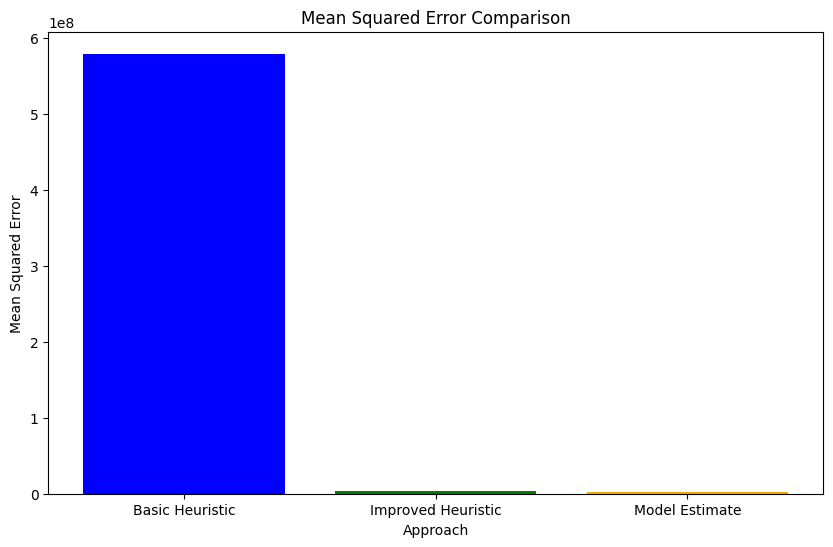

In [64]:
'''
The mse wasn't running due to NaN errors, so I did a further imputation on the test set
Duplicated a new comparison df here
'''
X_test_imputed = imputer.transform(X_test)

# Predict distances for the test set using the model
predicted_distances_model = model.predict(X_test_imputed)


comparison_df = pd.DataFrame({
    'Basic Heuristic': data.loc[X_test.index, 'BasicHeuristic'],
    'Improved Heuristic': data.loc[X_test.index, 'NewHeuristic'],
    'Model Estimate': predicted_distances_model,
    'Dataset value': y_test
})

# handling NaN's
comparison_df.dropna(inplace=True)

# Calculate Mean Squared Error for each approach
mse_basic_heuristic = mean_squared_error(comparison_df['Dataset value'], comparison_df['Basic Heuristic'])
mse_improved_heuristic = mean_squared_error(comparison_df['Dataset value'], comparison_df['Improved Heuristic'])
mse_model = mean_squared_error(comparison_df['Dataset value'], comparison_df['Model Estimate'])


print("Mean Squared Error (Basic Heuristic):", mse_basic_heuristic)
print("Mean Squared Error (Improved Heuristic):", mse_improved_heuristic)
print("Mean Squared Error (Model Estimate):", mse_model)

# Visualize Mean Squared Errors
plt.figure(figsize=(10, 6))
approaches = ['Basic Heuristic', 'Improved Heuristic', 'Model Estimate']
mse_values = [mse_basic_heuristic, mse_improved_heuristic, mse_model]
plt.bar(approaches, mse_values, color=['blue', 'green', 'orange'])
plt.xlabel('Approach')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error Comparison')
plt.show()


## Inference
### It does seem that the MSE for the basic heuristic is high, this could be a nice motivation for choosing an improved heuristic as the baseline for the Random Forest model.


## Footnotes    
- https://www.icrontech.com/blog_item/which-algorithmic-tools-do-you-need-to-solve-your-supply-chain-problems
- https://www.icrontech.com/blog_item/optimization-vs-heuristics-which-is-the-right-approach-for-your-business
- https://enjoymachinelearning.com/blog/heuristic-algorithm-vs-machine-learning/
- https://towardsdatascience.com/a-case-for-heuristics-why-simple-solutions-often-win-in-data-science-a31967766daa
- https://www.sciencedirect.com/science/article/abs/pii/S0341816220301302
- https://statmodeling.stat.columbia.edu/2020/08/14/decision-making-under-uncertainty-heuristics-vs-models/
- https://stats.stackexchange.com/questions/300350/is-machine-learning-an-heuristic-method